In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
data = pd.read_csv('../houseprice.csv') 
data.shape

(1460, 81)

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [5]:
data.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


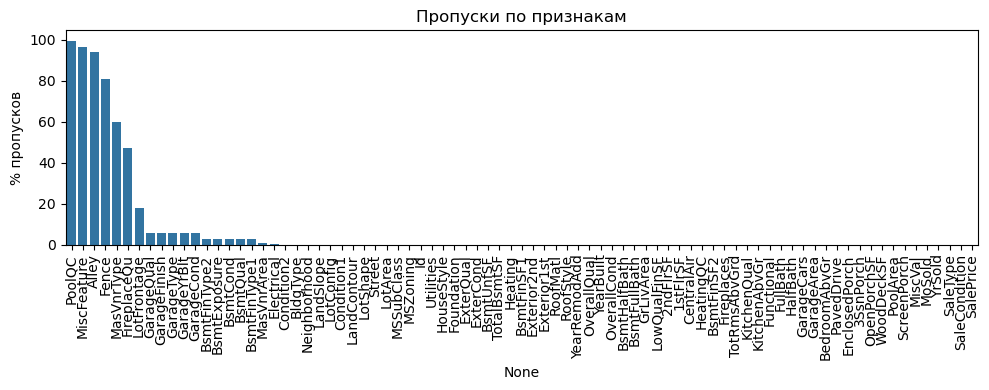

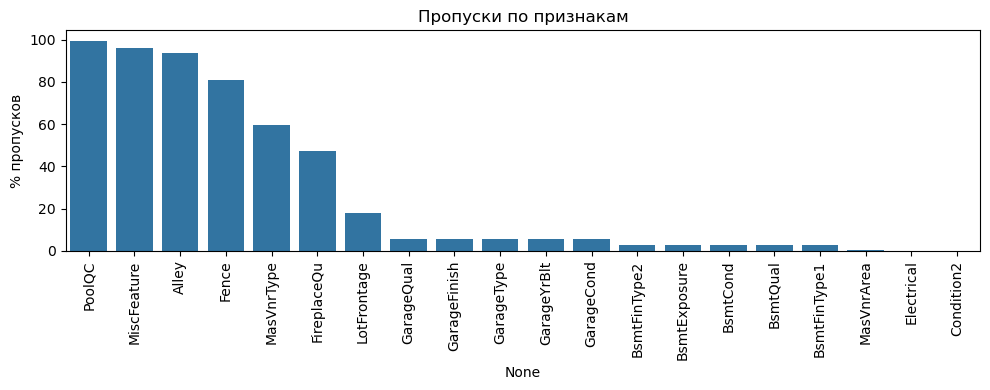

In [6]:
def plot_missing(df, top_n=None):
    pct = df.isnull().mean().sort_values(ascending=False) * 100
    if top_n:
        pct = pct.head(top_n)
    plt.figure(figsize=(10,4))
    sns.barplot(x=pct.index, y=pct.values)
    plt.xticks(rotation=90)
    plt.ylabel('% пропусков')
    plt.title('Пропуски по признакам')
    plt.tight_layout()
    plt.show()

plot_missing(data)
plot_missing(data, top_n=20)

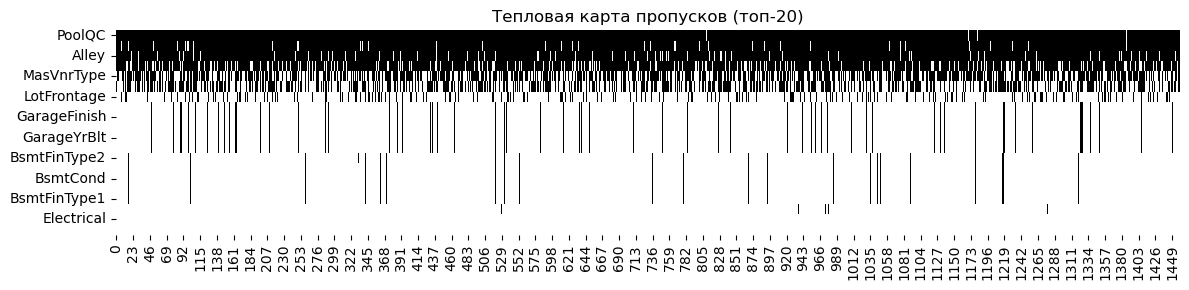

In [7]:
# Тепловая карта топ-20
top_cols = data.isnull().mean().sort_values(ascending=False).head(20).index
plt.figure(figsize=(12,3))
sns.heatmap(data[top_cols].isnull().T, cmap='gray_r', cbar=False)
plt.title('Тепловая карта пропусков (топ-20)')
plt.tight_layout()
plt.show()

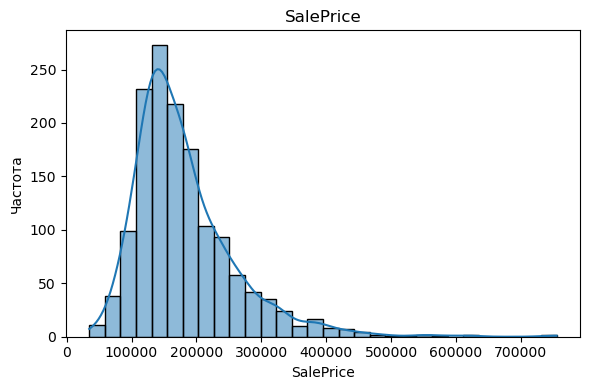

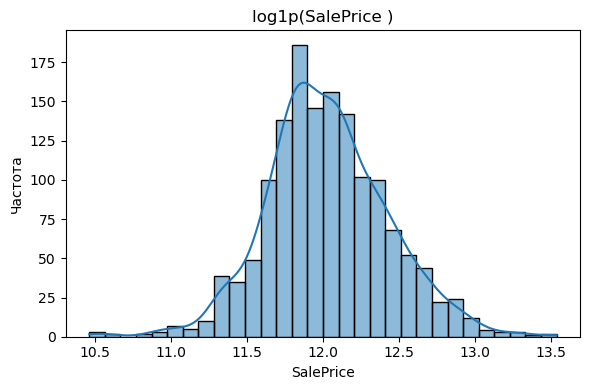

In [8]:

# --- 3. Распределение SalePrice ---
def plot_dist(feature, df, log=False):
    vals = np.log1p(df[feature]) if log else df[feature]
    plt.figure(figsize=(6,4))
    sns.histplot(vals, kde=True, bins=30)
    plt.title(f"{'log1p(' if log else ''}{feature}{' )' if log else ''}")
    plt.xlabel(feature)
    plt.ylabel('Частота')
    plt.tight_layout()
    plt.show()

plot_dist('SalePrice', data)
plot_dist('SalePrice', data, log=True)


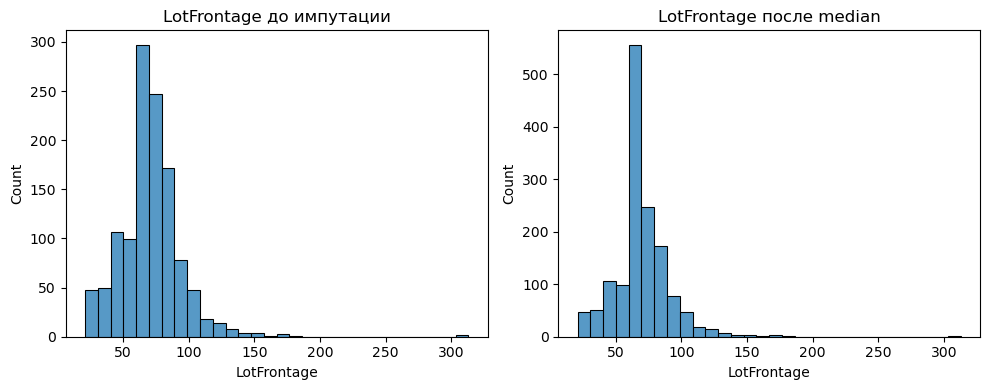

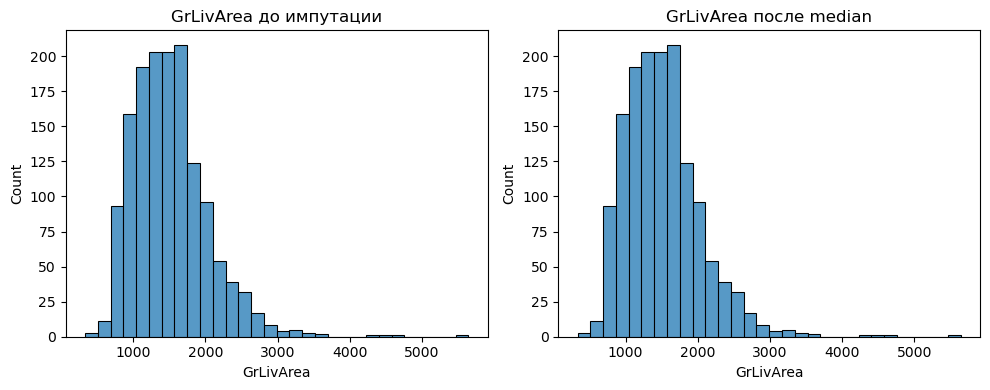

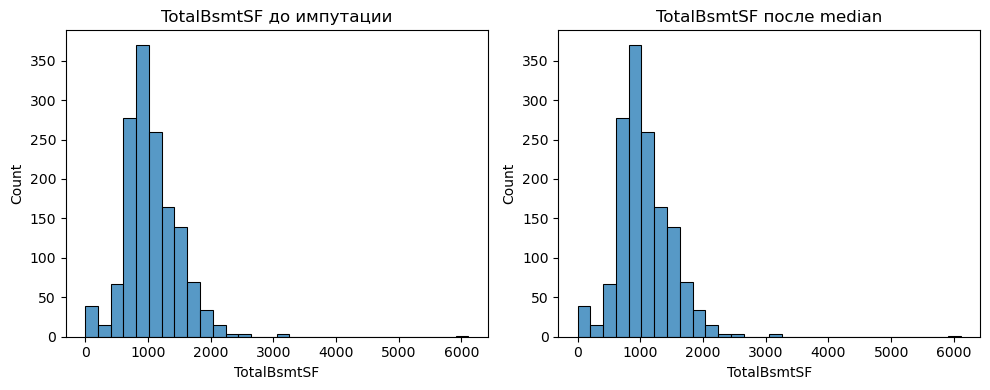

In [9]:
# --- 4. Сравнение до/после импутации ---
def compare_impute(feature, df, strategy='median'):
    tmp = df.copy()
    fill = tmp[feature].median() if strategy=='median' else tmp[feature].mean()
    before = tmp[feature].dropna()
    tmp[feature] = tmp[feature].fillna(fill)
    fig, ax = plt.subplots(1,2, figsize=(10,4))
    sns.histplot(before, ax=ax[0], bins=30)
    ax[0].set_title(f'{feature} до импутации')
    sns.histplot(tmp[feature], ax=ax[1], bins=30)
    ax[1].set_title(f'{feature} после {strategy}')
    plt.tight_layout()
    plt.show()

for feat in ['LotFrontage','GrLivArea','TotalBsmtSF']:
    compare_impute(feat, data)

In [10]:
# --- 5. Предобработка через Pipeline ---
# 5.1 Создаем новые признаки
data['TotalBath']    = data['FullBath'] + 0.5*data['HalfBath'] + data['BsmtFullBath'] + 0.5*data['BsmtHalfBath']
cols_porch = ['OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch','WoodDeckSF']
data['TotalPorchSF'] = data[cols_porch].sum(axis=1)
cols_sf = ['TotalBsmtSF','1stFlrSF','2ndFlrSF']
data['TotalSF']      = data[cols_sf].sum(axis=1)
data['HouseAge']     = data['YrSold'] - data['YearBuilt']
data['RemodAge']     = data['YrSold'] - data['YearRemodAdd']
data['GarageAge']    = data['YrSold'] - data['GarageYrBlt']
data['TotalRooms']   = data['TotRmsAbvGrd'] + data['BedroomAbvGr']

In [11]:
# 5.2 Определяем числовые и категориальные примеры
features = data.drop('SalePrice', axis=1)
numerical = features.select_dtypes(include=np.number).columns.tolist()
# Категории: все object
categorical = features.select_dtypes(include=['object']).columns.tolist()

In [12]:
# 5.3 Строим preprocessing pipelines
num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
cat_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='None')),
    ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore'))
])
preprocessor = ColumnTransformer([
    ('num', num_pipe, numerical),
    ('cat', cat_pipe, categorical)
])